<a href="https://colab.research.google.com/github/famemov/ml-student-stress-prediction/blob/main/students_stress.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ
✅ Файл 'student_stress_sleep_screen.csv' успешно загружен.
📊 Размер датасета: 500 записей
   study_hours  sleep_hours  screen_time_hours stress_level
0          7.4          5.9                2.7       Medium
1          4.6          5.9                7.6         High
2          2.0          8.0                3.2          Low
3          4.4          7.8               11.4       Medium
4          6.7          6.0                2.9       Medium

2. ПОДГОТОВКА ДАННЫХ (АЛГОРИТМЫ ПРЕДОБРАБОТКИ)
✅ Кодирование классов: {0: 'High', 1: 'Low', 2: 'Medium'}
✅ Данные стандартизированы (Mean=0, Std=1)

3. СОЗДАНИЕ НЕЙРОННОЙ СЕТИ (АРХИТЕКТУРА)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_16 (Dense)                │ (None, 64)             │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_19 (Dense)                │ (None, 3)              │            51 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,915 (11.39 KB)

 Trainable params: 2,915 (11.39 KB)

 Non-trainable params: 0 (0.00 B)


4. ОБУЧЕНИЕ МОДЕЛИ
Epoch 1/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.6214 - loss: 1.0002 - val_accuracy: 0.7500 - val_loss: 0.8289
Epoch 2/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.6402 - loss: 0.8502 - val_accuracy: 0.7500 - val_loss: 0.6486
Epoch 3/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - accuracy: 0.6883 - loss: 0.6992 - val_accuracy: 0.8200 - val_loss: 0.5179
Epoch 4/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7360 - loss: 0.5842 - val_accuracy: 0.8700 - val_loss: 0.4040
Epoch 5/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8516 - loss: 0.4425 - val_accuracy: 0.9600 - val_loss: 0.3070
Epoch 6/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8812 - loss: 0.3609 - val_accuracy: 0.9700 - val_loss: 0.2446
Epoch 7/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9010 - loss: 0.2756 - val_accuracy: 0.9500 - val_loss: 0.1951
Epoch 8/20
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.9246 - loss: 0.2387 - val_accura

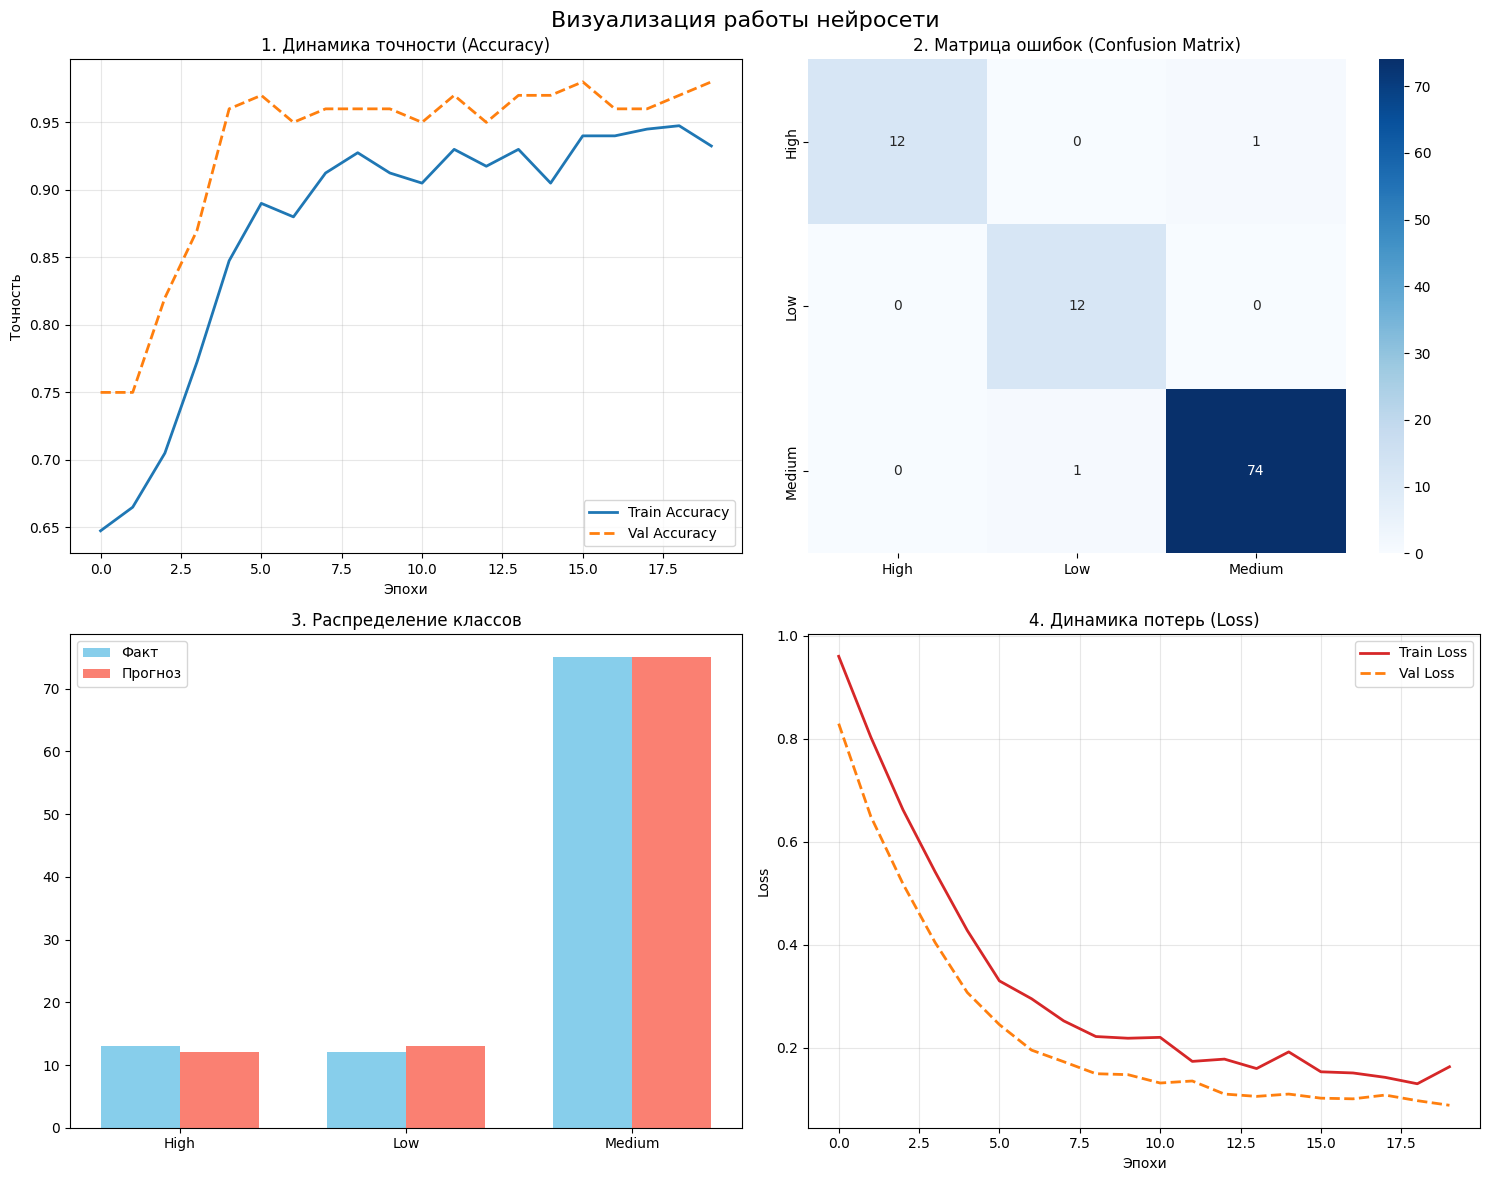


6. ИНТЕРАКТИВНОЕ ПРИЛОЖЕНИЕ (КАЛЬКУЛЯТОР)



🎉 ПРОГРАММА УСПЕШНО ЗАВЕРШЕНА!


In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                             precision_score, recall_score, f1_score, log_loss)
import ipywidgets as widgets
from IPython.display import display, HTML
import warnings

warnings.filterwarnings('ignore')

# Константы
TEST_SIZE = 0.2
RANDOM_STATE = 42

def load_and_analyze_data(filename='student_stress_sleep_screen.csv'):
    """Загружает и проводит первичный анализ данных"""
    print("\n" + "=" * 60)
    print("1. ЗАГРУЗКА И АНАЛИЗ ДАННЫХ")
    print("=" * 60)

    try:
        df = pd.read_csv(filename)
        print(f"✅ Файл '{filename}' успешно загружен.")
    except FileNotFoundError:
        print(f"❌ Файл '{filename}' не найден. Пожалуйста, загрузите его в Colab.")
        return None, None, None

    # Основные признаки
    features = ['study_hours', 'sleep_hours', 'screen_time_hours']
    target = 'stress_level'

    # Удаление пропусков
    df = df.dropna(subset=features + [target])

    print(f"📊 Размер датасета: {df.shape[0]} записей")
    print(df[features + [target]].head())

    return df, features, target

def prepare_data(df, features_col, target_col):
    """Подготавливает данные: кодирование, стандартизация, разделение"""
    print("\n" + "=" * 60)
    print("2. ПОДГОТОВКА ДАННЫХ (АЛГОРИТМЫ ПРЕДОБРАБОТКИ)")
    print("=" * 60)

    X = df[features_col].values
    y = df[target_col].values

    # Алгоритм 1: Label Encoding
    le = LabelEncoder()
    y_encoded = le.fit_transform(y)
    class_names = le.classes_
    print(f"✅ Кодирование классов: {dict(enumerate(class_names))}")

    # Алгоритм 2: Разделение выборки
    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=TEST_SIZE, random_state=RANDOM_STATE
    )

    # Алгоритм 3: Стандартизация (StandardScaler)
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    print(f"✅ Данные стандартизированы (Mean=0, Std=1)")

    return X_train_scaled, X_test_scaled, y_train, y_test, class_names, scaler

def create_model(input_dim, num_classes):
    """Создает архитектуру нейронной сети"""
    print("\n" + "=" * 60)
    print("3. СОЗДАНИЕ НЕЙРОННОЙ СЕТИ (АРХИТЕКТУРА)")
    print("=" * 60)

    # Архитектура MLP
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_dim,)), # Входной слой
        Dropout(0.2),                                           # Регуляризация
        Dense(32, activation='relu'),                           # Скрытый слой
        Dropout(0.2),
        Dense(16, activation='relu'),                           # Скрытый слой 2
        Dense(num_classes, activation='softmax')                # Выходной слой
    ])

    # Алгоритм 4: Оптимизация Adam
    model.compile(optimizer=Adam(learning_rate=0.001),
                  loss='sparse_categorical_crossentropy', # Алгоритм функции потерь
                  metrics=['accuracy'])

    model.summary()
    return model

def train_model(model, X_train, y_train, X_test, y_test):
    """Обучает модель"""
    print("\n" + "=" * 60)
    print("4. ОБУЧЕНИЕ МОДЕЛИ")
    print("=" * 60)

    # Алгоритм 5: Обратное распространение ошибки (Backpropagation) внутри fit
    history = model.fit(
        X_train, y_train,
        epochs=20,
        batch_size=16,
        validation_data=(X_test, y_test),
        verbose=1
    )
    return history

def analyze_and_visualize(model, history, X_test, y_test, class_names):
    """Визуализация результатов и расширенные метрики"""
    print("\n" + "=" * 60)
    print("5. АНАЛИЗ РЕЗУЛЬТАТОВ И МЕТРИКИ")
    print("=" * 60)

    # Предсказания
    y_pred_probs = model.predict(X_test, verbose=0)
    y_pred = np.argmax(y_pred_probs, axis=1)

    # --- РАСЧЕТ МЕТРИК ---
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, average='weighted')
    rec = recall_score(y_test, y_pred, average='weighted')
    f1 = f1_score(y_test, y_pred, average='weighted')
    loss = log_loss(y_test, y_pred_probs)

    # Функция для статуса
    def get_status(value, metric_type='high_is_good'):
        if metric_type == 'high_is_good':
            if value > 0.90: return "✅ Отлично"
            elif value > 0.80: return "⚠️ Хорошо"
            else: return "❌ Требует улучшения"
        else: # low_is_good (для Loss)
            if value < 0.3: return "✅ Отлично"
            elif value < 0.6: return "⚠️ Хорошо"
            else: return "❌ Плохо"

    print("\n📊 ИТОГОВАЯ ТАБЛИЦА МЕТРИК:")
    print("-" * 80)
    print(f"{'Метрика':<20} {'Значение':<15} {'Статус':<20}")
    print("-" * 80)
    print(f"{'Accuracy':<20} {acc:<15.4f} {get_status(acc)}")
    print(f"{'Precision':<20} {prec:<15.4f} {get_status(prec)}")
    print(f"{'Recall':<20} {rec:<15.4f} {get_status(rec)}")
    print(f"{'F1-Score':<20} {f1:<15.4f} {get_status(f1)}")
    print(f"{'Log Loss':<20} {loss:<15.4f} {get_status(loss, 'low_is_good')}")
    print("-" * 80)

    # --- ВИЗУАЛИЗАЦИЯ 2x2 ---
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    plt.suptitle('Визуализация работы нейросети', fontsize=16)

    # 1. График Точности (Accuracy)
    axes[0, 0].plot(history.history['accuracy'], label='Train Accuracy', linewidth=2)
    axes[0, 0].plot(history.history['val_accuracy'], label='Val Accuracy', linewidth=2, linestyle='--')
    axes[0, 0].set_title('1. Динамика точности (Accuracy)')
    axes[0, 0].set_xlabel('Эпохи')
    axes[0, 0].set_ylabel('Точность')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Матрица ошибок
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0, 1],
                xticklabels=class_names, yticklabels=class_names)
    axes[0, 1].set_title('2. Матрица ошибок (Confusion Matrix)')

    # 3. Сравнение Факт vs Прогноз
    unique, counts_true = np.unique(y_test, return_counts=True)
    unique_pred, counts_pred = np.unique(y_pred, return_counts=True)
    width = 0.35
    x = np.arange(len(class_names))
    axes[1, 0].bar(x - width/2, counts_true, width, label='Факт', color='skyblue')
    axes[1, 0].bar(x + width/2, counts_pred, width, label='Прогноз', color='salmon')
    axes[1, 0].set_title('3. Распределение классов')
    axes[1, 0].set_xticks(x)
    axes[1, 0].set_xticklabels(class_names)
    axes[1, 0].legend()

    # 4. График Потерь (Loss) - ИЗМЕНЕНО ПО ВАШЕМУ ЗАПРОСУ
    axes[1, 1].plot(history.history['loss'], label='Train Loss', linewidth=2, color='tab:red')
    axes[1, 1].plot(history.history['val_loss'], label='Val Loss', linewidth=2, linestyle='--', color='tab:orange')
    axes[1, 1].set_title('4. Динамика потерь (Loss)')
    axes[1, 1].set_xlabel('Эпохи')
    axes[1, 1].set_ylabel('Loss')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def run_interactive_app(model, scaler, class_names, features):
    """Интерактивное приложение с виджетами"""
    print("\n" + "=" * 60)
    print("6. ИНТЕРАКТИВНОЕ ПРИЛОЖЕНИЕ (КАЛЬКУЛЯТОР)")
    print("=" * 60)

    style = {'description_width': 'initial'}
    layout = widgets.Layout(width='60%')

    # Виджеты
    w_study = widgets.FloatSlider(value=5, min=0, max=16, step=0.5, description='Часы учебы:', style=style, layout=layout)
    w_sleep = widgets.FloatSlider(value=7, min=2, max=12, step=0.5, description='Часы сна:', style=style, layout=layout)
    w_screen = widgets.FloatSlider(value=4, min=0, max=14, step=0.5, description='Экранное время:', style=style, layout=layout)

    btn = widgets.Button(description="Рассчитать стресс", button_style='primary', layout=widgets.Layout(width='30%'))
    out = widgets.Output()

    def on_click_predict(b):
        with out:
            out.clear_output()
            # Подготовка данных
            input_df = pd.DataFrame([[w_study.value, w_sleep.value, w_screen.value]], columns=features)
            input_scaled = scaler.transform(input_df)

            # Прогноз
            probs = model.predict(input_scaled, verbose=0)[0]
            pred_idx = np.argmax(probs)
            pred_label = class_names[pred_idx]

            # Визуализация полосок
            colors = {"Low": "#4CAF50", "Medium": "#FF9800", "High": "#F44336"}
            bars_html = ""
            for name, p in zip(class_names, probs):
                perc = p * 100
                color = colors.get(name, "#999")
                bars_html += f"""
                <div style="margin: 5px 0;">
                    <div style="display:flex; justify-content:space-between;"><b>{name}</b><span>{perc:.1f}%</span></div>
                    <div style="background:#eee; height:10px; border-radius:5px;"><div style="width:{perc}%; background:{color}; height:100%; border-radius:5px;"></div></div>
                </div>"""

            display(HTML(f"""
            <div style="border:2px solid #333; padding:15px; border-radius:10px; width:100%;">
                <h3>Результат: <span style="color:{colors.get(pred_label)}">{pred_label}</span></h3>
                <hr>{bars_html}
            </div>
            """))

    btn.on_click(on_click_predict)
    display(widgets.VBox([w_study, w_sleep, w_screen, btn, out]))

def main():
    # 1. Загрузка
    df, features, target = load_and_analyze_data()
    if df is None: return

    # 2. Подготовка
    X_train, X_test, y_train, y_test, class_names, scaler = prepare_data(df, features, target)

    # 3. Создание модели
    model = create_model(input_dim=X_train.shape[1], num_classes=len(class_names))

    # 4. Обучение
    history = train_model(model, X_train, y_train, X_test, y_test)

    # 5. Анализ и Метрики
    analyze_and_visualize(model, history, X_test, y_test, class_names)

    # 6. Интерактив
    run_interactive_app(model, scaler, class_names, features)

    print("\n" + "=" * 60)
    print("🎉 ПРОГРАММА УСПЕШНО ЗАВЕРШЕНА!")
    print("=" * 60)

if __name__ == '__main__':
    main()